In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import h5py
import matplotlib.pyplot as plt
'''import inflect
c2h.stringify = inflect.engine()'''
from tqdm import tqdm
from collections import Counter
import csv_to_hdf5 as c2h
import obspy
import math
import creep_event_picker as cep

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [4]:
directory = '../../Data/DATA_tidied/HDF5/'  # Replace with your actual directory path
files = c2h.list_files_in_directory(directory)
print(files)
del files[10]
files.sort()
del files[1],files[25],files[25],files[25],files[25],files[25],files[25],files[25],files[29],files[37],files[42],files[45],files[45],files[53],files[53],files[54]
print(files)

['HWP1.h5', 'ORM1.h5', 'XPH1.h5', 'XHR3.h5', 'XSJ2.h5', 'XPK1.h5', 'TEP1.h5', 'PET1.h5', 'HWE1.h5', 'HWR1.h5', '.DS_Store', 'KIR1.h5', 'RB.h5', 'HAM1.h5', 'HWW1.h5', 'XSC1.h5', 'CFW1.h5', 'CRR1.h5', 'GB.h5', 'XHR2.h5', 'XSJ3.h5', 'SJN1.h5', 'GOZ1.h5', 'CWN1.h5', 'SIV1.h5', 'XTA1.h5', 'C462.h5', 'CWC3.h5', 'XMP1.h5', 'GOK1.h5', 'INW1.h5', 'TWR1.h5', 'XHSW.h5', 'XMD1.h5', 'PAN1.h5', 'WSZ1.h5', 'XMBC.h5', 'XMR1.h5', 'COZ1.h5', 'C461.h5', 'XMP2.h5', 'X461.h5', 'XVA1.h5', 'TABC.h5', 'BIT1.h5', 'WKR1.h5', 'TAS1.h5', 'GS.h5', 'XRSW.h5', 'PAS1.h5', 'KAR1.h5', 'CTM1.h5', 'SHR2.h5', 'CAN1.h5', 'XMM1.h5', 'SEL1.h5', 'CHP1.h5', 'XGH1.h5', 'HAT1.h5', 'XFL1.h5', 'HLD1.h5', 'RA.h5', 'FCR1.h5', 'YZW1.h5', 'XHR1.h5', 'CHE1.h5', 'CHA1.h5', 'CPP1.h5', 'MRW1.h5', 'ESZ1.h5', 'ISW1.h5', 'YZE1.h5', 'XDL2.h5', 'HLC1.h5', 'HAS1.h5', 'R7.h5', 'XPK2.h5', 'CER1.h5', 'XSH1.h5', 'GD.h5', 'BAL1.h5', 'HWR2.h5']
['BAL1.h5', 'C461.h5', 'C462.h5', 'CAN1.h5', 'CER1.h5', 'CFW1.h5', 'CHA1.h5', 'CHE1.h5', 'CHP1.h5', 'COZ1.h

In [12]:
files = ['CHE1.h5']

In [13]:
frequency_dict = {
        1/60: '1S',    # 1 second
        1/6: '10S',  # 10 seconds
        1/2: '30S',  # 30 seconds
        1: '1T',  # 1 minute
        2: '2T',  # 2 minutes
        5: '5T',  # 5 minutes
        10: '10T',# 10 minutes
        30: '30T',# 30 minutes
        60: '60T'    # 60 minutes
    }

In [14]:
def interpolate(time,slip, freq):
    creeping_df = pd.DataFrame({'Time':time,'Tm':time,'Slip':slip})
    creeping_df.Time = creeping_df.Time.dt.round(freq) #round creep times to nearest mins (make evenly spaced)
    creeping_df.Tm = creeping_df.Tm.dt.round(freq)
    creeping_df.set_index('Time',inplace=True) #set index of the dataframe
    creeping_df.drop_duplicates(subset=['Tm'], inplace=True) 
    upsampled = creeping_df.resample(freq).ffill(1)
    return upsampled

In [15]:
try:
    Creepmeter_dataframe_SAC = pd.read_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv',index_col=0)
except FileNotFoundError:
    Creepmeter_dataframe_SAC = pd.DataFrame()


In [16]:
Creepmeter_dataframe_SAC

,Network,Creepmeter_abbrv,File_code,Start Time,End Time,"Sampling rate, Hz","Sampling rate, mins",Latitude,Longitude,Length,Depth,Obliquity,data source,picked
84,HOL,XMR1,XMR1_10T,1980-01-30T00:00:00.000000Z,2014-03-11T20:30:00.000000Z,0.001667,10T,36.5950,-121.1870,10 m,cm,30,USGS,Yes
75,HOL,XHR1,XHR1_10T,1981-09-15T00:00:00.000000Z,1986-12-05T23:50:00.000000Z,0.001667,10T,36.7720,-121.4220,30 m,NaN,22,USGS,Yes
82,PARK,XMM1,XMM1_10T,1984-09-26T00:00:00.000000Z,2023-04-26T07:50:00.000000Z,0.001667,10T,35.9580,-120.5020,26 m,1 m,30,USGS,Yes
74,PARK,XGH1,XGH1_10T,1985-04-03T00:00:00.000000Z,2022-06-28T09:10:00.000000Z,0.001667,10T,35.8200,-120.3480,10 m,cm,30,USGS,Yes
88,PARK,XSC1,XSC1_10T,1985-04-12T00:00:00.000000Z,2022-11-15T00:00:00.000000Z,0.001667,10T,36.0650,-120.6280,10 m,cm,27,USGS,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,EAF,TAS1,TAS1_1T,2023-06-01T10:55:00.000000Z,2024-05-26T09:07:00.000000Z,0.016667,1T,38.2049,38.7872,52 (originally 9m),NaN,30,Roger,Yes
45,EAF,KAR1,KAR1_1T,2023-06-05T05:38:00.000000Z,2024-05-26T06:49:00.000000Z,0.016667,1T,38.0697,38.4983,6 m,NaN,30,Roger,Yes
94,EAF,YZE1,YZE1_1T,2023-09-07T10:36:07.000000Z,2024-05-26T12:59:07.000000Z,0.016667,1T,38.1791,38.7526,20 m,NaN,30,Roger,Yes
77,HOL,XHR3,XHR3_1T,2024-02-28T23:21:00.000000Z,2024-10-09T19:27:00.000000Z,0.016667,1T,36.7720,-121.4220,30 m,NaN,22,USGS,NaN


CHE1 0
['CHE1_0.5mins', 'CHE1_1.0mins', 'CHE1_5.0mins', 'Temperature']
Key: CHE1_0.5mins
['Slip_CHE1_0.5mins', 'Time_CHE1_0.5mins']
CHE1_30S
2020-05-01T17:52:26.000000Z


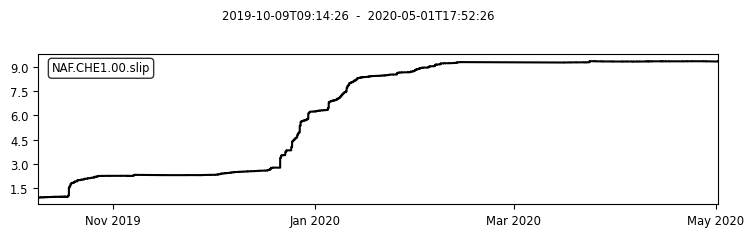

Key: CHE1_1.0mins
['Slip_CHE1_1.0mins', 'Time_CHE1_1.0mins']
CHE1_1T
2019-10-08T13:39:00.000000Z


/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/util.py:266: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small')
/Users/dagi9522/miniconda3/envs/creepmeters/lib/python3.10/site-packages/obspy/imaging/waveform.py:815: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 6.
  plt.setp(ax.get_xticklabels(), fontsize='small',


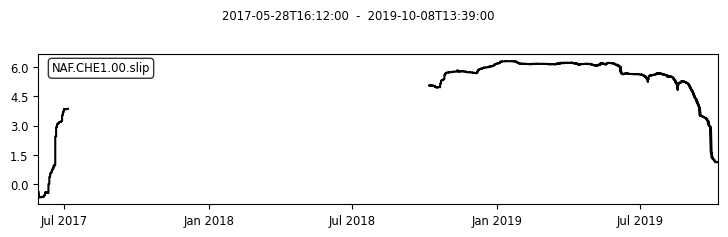

Key: CHE1_5.0mins
['Slip_CHE1_5.0mins', 'Time_CHE1_5.0mins']
CHE1_5T
2018-10-04T15:51:22.000000Z


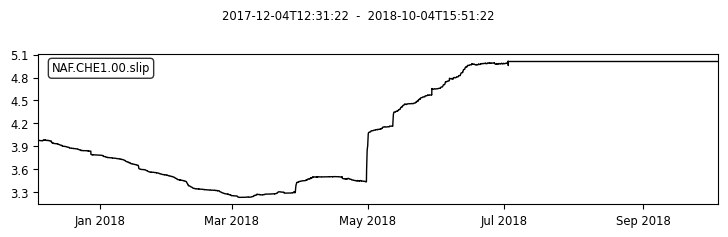

In [17]:
for i in range(len(files)):
    abbreviation = files[i][:4]
    if abbreviation[2]=='.':
        abbreviation = abbreviation[:2]
    print(abbreviation,i)
    # Open the HDF5 file in read mode
    with h5py.File('../../Data/DATA_tidied/HDF5/{k}.h5'.format(k=abbreviation), 'r') as f:
        try:
            author = f.attrs['author']
        except KeyError:
            print('no author')
        network = f.attrs['network']
        latitude = f.attrs['latitude']
        longitude = f.attrs['longitude']
        depth = f.attrs['depth']
        length = f.attrs['length'] 
        obliquity = f.attrs['obliquity']
        # Loop through each key in the file
        keys = list(f.keys())
        print(keys)
        
        for key in f.keys():
            if key not in ['Temperature','Daily_measurements','Manual_measurements','Orthogonal']:
                print("Key:", key)
                data = f[key]  # Access the dataset
                data_keys = list(data.keys())
                print(data_keys)
                slip = data[data_keys[0]][:]
                time =  data[data_keys[1]][:]
                decoded_time = [byte_str.decode('utf-8') for byte_str in time]
                decoded_time = pd.to_datetime(decoded_time)

                smpl_rate = data.attrs['sampling_rate']   
                time_units = data.attrs['time_units']     
                slip_units = data.attrs['slip_units']  
                channel = data.attrs['channel'] 
                starttime = data.attrs['starttime'] 
                delta = data.attrs['delta']
                freq_chosen = frequency_dict[smpl_rate]
                upsampled = interpolate(decoded_time,slip,freq_chosen)


                tr = obspy.Trace(np.array(upsampled['Slip']))
                st = obspy.Stream(tr)
                st[0].stats.network = network
                st[0].stats.station = abbreviation
                st[0].stats.location = '00'
                st[0].stats.channel = channel
                st[0].stats.starttime = starttime
                st[0].stats.delta = delta
                st[0].stats['latitude'] = latitude
                st[0].stats['longitude'] = longitude
                st[0].stats['length'] = length
                st[0].stats['depth'] = depth
                st[0].stats['obliquity'] = obliquity
                file_code = abbreviation + '_{k}'.format(k=freq_chosen)
                
                print(file_code)
                print(st[0].stats.endtime)
                tr.plot();
                instrument = pd.DataFrame({'Network':[st[0].stats.network],'Creepmeter_abbrv':['{k}'.format(k=abbreviation)],'File_code':[file_code],
                                            'Start Time':[st[0].stats.starttime],'End Time':[st[0].stats.endtime],'Sampling rate, Hz':[st[0].stats.sampling_rate],
                                            'Sampling rate, mins':[freq_chosen],'Latitude':[latitude],'Longitude':[longitude],'Length':[length],'Depth':[depth],
                                            'Obliquity':[obliquity]})
                
                Creepmeter_dataframe_SAC = pd.concat([Creepmeter_dataframe_SAC,instrument],ignore_index=True)
                
                Creepmeter_dataframe_SAC.drop_duplicates(subset='File_code',inplace=True)
                Creepmeter_dataframe_SAC.reset_index(inplace=True,drop=True)
                
                Creepmeter_dataframe_SAC.to_csv('../../Data/DATA_tidied/creepmeter_metadata_post_standardisation_sac_codes.csv')
                st.write('../../Data/DATA_tidied/SAC/{k}.SAC'.format(k=file_code),format='SAC')

            

In [54]:
st = obspy.read('../../Data/DATA_tidied/SAC/')

In [ ]:
data.keys

In [ ]:
st[0].plot()

In [237]:
with h5py.File('../../Data/DATA_tidied/HDF5/SIV1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    old_group_name = 'SIV1_0.16667mins'
    new_group_name = 'SIV1_10s'
    old_dataset_name1 = 'Slip_SIV1_0.16667mins'
    new_dataset_name1 = 'Slip_SIV1_10s'
    old_dataset_name2 = 'Time_SIV1_0.16667mins'
    new_dataset_name2 = 'Time_SIV1_10s'
     # Check if the old group and dataset exist
    if old_group_name in f:
        # Create a new group
        new_group = f.create_group(new_group_name)
        #new_group = f[new_group_name]

        new_group.attrs['sampling_rate'] = f[old_group_name].attrs['sampling_rate']  # Example: 100 Hz sampling rate (10 ms interval)
        new_group.attrs['time_units'] = 'minutes'     # Time units
        new_group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        new_group.attrs['channel'] = 'slip'
        new_group.attrs['starttime'] = f[old_group_name].attrs['starttime']
        new_group.attrs['delta'] = f[old_group_name].attrs['delta']
        # Copy the dataset from the old group to the new group
        if old_dataset_name1 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name1][:]
            new_group.create_dataset(new_dataset_name1, data=data)

        
        # Copy the dataset from the old group to the new group
        if old_dataset_name2 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name2][:]
            new_group.create_dataset(new_dataset_name2, data=data)

    

['SIV1_0.16667mins', 'SIV1_1.0mins', 'Temperature']


In [238]:
with h5py.File('../../Data/DATA_tidied/HDF5/SIV1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    del f['SIV1_0.16667mins']
    keys = list(f.keys())
    print(keys)

['SIV1_0.16667mins', 'SIV1_1.0mins', 'SIV1_10s', 'Temperature']
['SIV1_1.0mins', 'SIV1_10s', 'Temperature']


In [249]:
with h5py.File('../../Data/DATA_tidied/HDF5/FXC1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    old_group_name = 'FXC1_1.0mins'
    new_group_name = 'FCR1_1.0mins'
    old_dataset_name1 = 'Slip_FXC1_1.0mins'
    new_dataset_name1 = 'Slip_FCR1_1.0mins'
    old_dataset_name2 = 'Time_FXC1_1.0mins'
    new_dataset_name2 = 'Time_FCR1_1.0mins'
     # Check if the old group and dataset exist
    if old_group_name in f:
        # Create a new group
        new_group = f.create_group(new_group_name)
        #new_group = f[new_group_name]

        new_group.attrs['sampling_rate'] = f[old_group_name].attrs['sampling_rate']  # Example: 100 Hz sampling rate (10 ms interval)
        new_group.attrs['time_units'] = 'minutes'     # Time units
        new_group.attrs['slip_units'] = 'millimetres'  # Dependent variable units (e.g., for slip)
        new_group.attrs['channel'] = 'slip'
        new_group.attrs['starttime'] = f[old_group_name].attrs['starttime']
        new_group.attrs['delta'] = f[old_group_name].attrs['delta']
        # Copy the dataset from the old group to the new group
        if old_dataset_name1 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name1][:]
            new_group.create_dataset(new_dataset_name1, data=data)

        
        # Copy the dataset from the old group to the new group
        if old_dataset_name2 in f[old_group_name]:
            data = f[old_group_name][old_dataset_name2][:]
            new_group.create_dataset(new_dataset_name2, data=data)

['FXC1_1.0mins', 'Orthogonal', 'Temperature']


In [256]:
with h5py.File('../../Data/DATA_tidied/HDF5/FCR1.h5', 'r+') as f:
    keys = list(f.keys())
    print(keys)
    del f['FXC1_1.0mins']
    keys = list(f.keys())
    print(keys)

['FCR1_1.0mins', 'FXC1_1.0mins', 'Orthogonal', 'Temperature']
['FCR1_1.0mins', 'Orthogonal', 'Temperature']


In [254]:
data

array([25.94, 25.94, 25.94, ..., 12.44, 12.41, 12.44])